In [15]:
import os
from glob import glob
from os.path import join, basename
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erfc, erf
import matplotlib.dates as mdates
from os.path import join, basename
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from obspy.imaging.cm import viridis_white_r
from matplotlib.ticker import LogLocator, FixedLocator, FixedFormatter, MultipleLocator, AutoMinorLocator
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.transforms as transforms
from matplotlib.font_manager import FontProperties
# from sklearn.metrics import r2_score
from scipy import signal
from obspy.signal.regression import linear_regression
import datetime

In [16]:
def resolve_dtp(tps):
    tps /= 1000
    P = tps.mean(axis=0)
    Delta_P = [0]
    rho = 1000
    g = 9.81
    for i in range(1, len(P)):
        delta_P = P[i] - np.mean(P[:i])
        # delta_P = P[i] - np.mean(P[:])

        Delta_P.append(delta_P*rho*g)

    Delta_P = np.array(Delta_P)

    return Delta_P

def cal_PorePressure(Delta_P, c):
    B, v = 0.7, 0.4
    z = 500
    dt = 3600
    n = len(Delta_P)
    Term1_coef = (B * (1 + v)) / (3 * (1 - v))

    ## Pore Pressure simulatiom Term1
    Pore_Term1 = [0]
    for i in range(1,len(Delta_P)):
        A = z / np.sqrt(4 * c * (n - i) * dt)
        sub_Term1 = np.sum(Delta_P[:i] * erf(A)) * Term1_coef
        Pore_Term1.append(sub_Term1)

    Pore_Term1 = np.array(Pore_Term1)

    ## Pore Pressure simulatiom Term2
    Pore_Term2 = [0]
    for i in range(1,len(Delta_P)):
        A = z / np.sqrt(4 * c * (n - i) * dt)
        sub_Term2 = np.sum(Delta_P[:i] * erfc(A))
        Pore_Term2.append(sub_Term2)

    Pore_Term2 = np.array(Pore_Term2)

    Pore_Change = Pore_Term1 + Pore_Term2

    return Pore_Change

In [17]:
seq_file = "../data/seq_dvov/Seq_dvov_rainfall.npz"

seq_dat = np.load(seq_file)
mean_dvov = seq_dat['mean_dvov']
tps = seq_dat['tps']

## Pore pressure simulation and optimum c searching

In [18]:
dtp = resolve_dtp(tps)

Diffs = np.arange(0.1, 10.1, 0.1)
# Diffs = [1]

thetas = []
model_dvovs = []
PCCs = []

for diff in Diffs:

    # c = diff

    pore_pressure = cal_PorePressure(dtp, diff)

    cov = np.cov(mean_dvov, pore_pressure)
    var = np.var(pore_pressure)
    k = cov[0, 1]/var
    model_dvov = k * (pore_pressure - np.mean(pore_pressure)) + np.mean(mean_dvov)
    theta = np.sum((mean_dvov - model_dvov)**2)

    thetas.append(theta)
    model_dvovs.append(model_dvov)
    PCCs.append(pore_pressure)



ind = np.where(thetas==np.min(thetas))[0][0]
opt_diff = Diffs[ind]
opt_model_dvov = model_dvovs[ind]
opt_pp = PCCs[ind]

## Plot the Figure 5

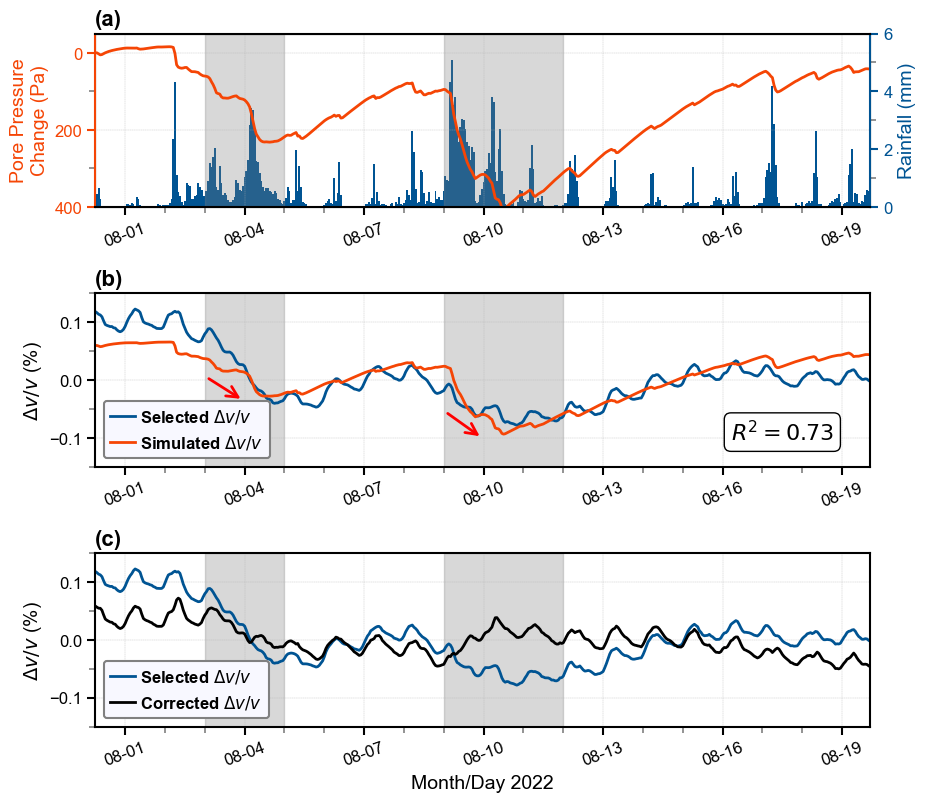

In [19]:
mpl.rc('font',family='Arial')

def ax_param_adjust(ax):
    ax.tick_params(axis='x', labelsize=12, rotation=20, width=1.5, length=6)
    ax.tick_params(axis='x', labelsize=12, rotation=20, width=1.2, length=4, which='minor', color='gray')

    ax.tick_params(axis = 'y', labelsize=12, width=1.5, length=6)
    ax.tick_params(axis='y', labelsize=12, width=1.2, length=4, which='minor', color='gray')

    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

def get_dates():
    start_time = datetime.datetime(2022, 7, 31, 6, 0, 0)
    end_time = datetime.datetime(2022, 8, 19, 18, 0, 0)

    delta = datetime.timedelta(hours=1)

    dates = []
    current = start_time
    while current < end_time:
        dates.append(current)
        current += delta
    return dates


stc1="2022-08-03"
etc1="2022-08-05"
tc1_start = mdates.datestr2num(stc1)
tc1_end = mdates.datestr2num(etc1)

tc1_x = (tc1_start + tc1_end) / 2

stc2="2022-08-09"
etc2="2022-08-12"
tc2_start = mdates.datestr2num(stc2)
tc2_end = mdates.datestr2num(etc2)

tc2_x = (tc2_start + tc2_end) / 2

fig5, ax = plt.subplots(3, 1, figsize=(10, 9), facecolor = "white")
fig5.subplots_adjust(hspace=0.5)

pore_pressure = opt_pp
model_dvov = opt_model_dvov
tps = tps
mean_dvov = mean_dvov

mean_tps = tps.mean(axis=0) * 1000

dates = get_dates()



'''
Fig5a
'''
pp_color = (245, 69, 5)
pp_color_norm = tuple(c/255 for c in pp_color)

prec_color = (0, 84, 147)
prec_color_norm = tuple(c/255 for c in prec_color)

ax1 = ax[0]
ax1.invert_yaxis()
ax1.grid(lw=0.25,ls='--')

ax1.axvspan(tc1_start, tc1_end, alpha=.3, color = 'gray')
ax1.axvspan(tc2_start, tc2_end, alpha=.3, color = 'gray')

transform = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
# ax1.text(tc1_x, 0.88, r"$\boldsymbol{R}_{1}$",
#             ha='center',
#             transform=transform,
#             fontsize=16, fontweight='bold',
#             clip_on=False)

# ax1.text(tc2_x, 0.88, r"$\boldsymbol{R}_{2}$",
#             ha='center',
#             transform=transform,
#             fontsize=16, fontweight='bold',
#             clip_on=False)

ax_param_adjust(ax1)

ax1.set_ylabel("Pore Pressure\nChange (Pa)", fontsize = 14)
ax1.set_xlim(dates[0], dates[-1])
ax1.spines['left'].set_color(pp_color_norm)
ax1.tick_params(axis='y', colors=pp_color_norm)
ax1.yaxis.label.set_color(pp_color_norm)

ax1_2 = ax1.twinx()
ax1_2.bar(dates, mean_tps, width=0.05, color=prec_color_norm)
ax1_2.set_zorder(0)
ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1.plot(dates, pore_pressure, linewidth=2, color=pp_color_norm)
ax1.yaxis.set_major_locator(MultipleLocator(200))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.set_ylim(400, -50)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax1.xaxis.set_minor_locator(AutoMinorLocator(3))

ax1.spines['right'].set_color(prec_color_norm)


ax1_2.yaxis.label.set_color(prec_color_norm)
ax1_2.tick_params(axis='y', colors=prec_color_norm)
ax1_2.set_ylim(0, 6)
ax1_2.set_ylabel("Rainfall (mm)", fontsize = 14)

ax1_2.yaxis.set_major_locator(MultipleLocator(2))
ax1_2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1_2.tick_params(axis = 'y', labelsize=12, width=1.5, length=6)
ax1_2.tick_params(axis='y', labelsize=12, width=1.2, length=4, which='minor', color='gray')

ax1.set_title("(a)",loc='left',fontsize=16, fontweight="bold")


'''
Fig5b
'''
ax2 = ax[1]
ax2.grid(lw=0.25,ls='--')


ax2.axvspan(tc1_start, tc1_end, alpha=.3, color = 'gray')
ax2.axvspan(tc2_start, tc2_end, alpha=.3, color = 'gray')

ax_param_adjust(ax2)
# ax2.scatter(dates, c1_mean_dvov*100, marker="o", color=prec_color_norm, label=r"Cluster-1 $\Delta$v/v", s=5)
# ax2.scatter(dates, model_dvov*100, marker="o", color=pp_color_norm, label=r"Simulated $\Delta$v/v", s=5)

ax2.plot(dates, mean_dvov*100, linewidth=2, color=prec_color_norm, label=r"Selected $\Delta v/v$")
ax2.plot(dates, model_dvov*100, linewidth=2, color=pp_color_norm, label=r"Simulated $\Delta v/v$")

'''
Cal and Plot the R2
'''
# r2 = r2_score(mean_dvov, model_dvov)
# print(r2)

r2_text="2022-08-17T12:00:00"
r2_x = mdates.datestr2num(r2_text)

transform_2 = transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
# ax2.text(r2_x, 0.15, r"$\boldsymbol{R}^{2}=0.63$",
#             ha='center',
#             transform=transform_2,
#             fontsize=16, fontweight='bold',
#             clip_on=False
#             ,bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

ax2.text(r2_x, 0.15, r"$R^{2}=0.73$",
            ha='center',
            transform=transform_2,
            fontsize=16, fontweight='bold',
            clip_on=False
            ,bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))



ax2.set_xlim(dates[0], dates[-1])
ax2.set_ylim(-0.15, 0.15)

ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax2.xaxis.set_minor_locator(AutoMinorLocator(3))

ax2.set_ylabel(r'$\Delta v/v$ (%)', fontsize = 14)
ax2.set_title("(b)",loc='left',fontsize=16, fontweight="bold")

ann_1_x = mdates.datestr2num("2022-08-03T01:00:00")

ann_2_x = mdates.datestr2num("2022-08-03T23:00:00")

ax2.annotate('', xytext=(ann_1_x, 0.005), xy=(ann_2_x, -0.035),
            arrowprops=dict(arrowstyle="->", linewidth=2, color='red',mutation_scale=20))

ann_3_x = mdates.datestr2num("2022-08-09T01:00:00")

ann_4_x = mdates.datestr2num("2022-08-09T23:00:00")

ax2.annotate('', xytext=(ann_3_x, -0.055), xy=(ann_4_x, -0.1),
            arrowprops=dict(arrowstyle="->", linewidth=2, color='red',mutation_scale=20))

bold_font = FontProperties(weight='bold', size=12)
legend = ax2.legend(
    loc='lower left',
    frameon=True,           
    facecolor='ghostwhite',      
    edgecolor='gray',
    handletextpad=0.3,
    handlelength=1.5,
    prop=bold_font
)

legend.get_frame().set_alpha(1) 
legend.get_frame().set_linewidth(1.5)

'''
Fig5c
'''
ax3 = ax[2]
ax3.grid(lw=0.25,ls='--')

ax3.axvspan(tc1_start, tc1_end, alpha=.3, color = 'gray')
ax3.axvspan(tc2_start, tc2_end, alpha=.3, color = 'gray')

ax3.plot(dates, mean_dvov*100, linewidth=2, color=prec_color_norm, label=r"Selected $\Delta v/v$")
ax3.plot(dates, (mean_dvov - model_dvov)*100, linewidth=2, color="black", label=r"Corrected $\Delta v/v$")
ax3.set_xlim(dates[0], dates[-1])
ax3.set_ylim(-0.15, 0.15)

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax3.xaxis.set_minor_locator(AutoMinorLocator(3))

ax3.yaxis.set_major_locator(MultipleLocator(0.1))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))

ax_param_adjust(ax3)

ax3.set_ylabel(r'$\Delta v/v$ (%)', fontsize = 14)
ax3.set_xlabel('Month/Day 2022', fontsize = 14)

ax3.set_title("(c)",loc='left',fontsize=16, fontweight="bold")

bold_font = FontProperties(weight='bold', size=12)
legend = ax3.legend(
    loc='lower left',
    frameon=True,           
    facecolor='ghostwhite',      
    edgecolor='gray',
    handletextpad=0.3,
    handlelength=1.5,
    prop=bold_font
)

legend.get_frame().set_alpha(1) 
legend.get_frame().set_linewidth(1.5)
